## Практическое задание к уроку № 5 по теме "Гибридные рекомендательные системы"

*Сделать грид серч модели, рассмотренной на уроке. Смотреть на метрику precision@5, считаем на тесте нашей функцией.*

Скопируем с урока код с инициализацией данных:

In [3]:
!pip install implicit==0.4.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.9 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3423206 sha256=f6f41875084895da89523252146930bd2c5509e53ea2354941a17c8e51155f00
  Stored in directory: /root/.cache/pip/wheels/44/7e/7d/a17324ea207cfbe76aca878b5b8ca0aa932cf55d163329be37
Successfully built implicit


In [4]:
!pip install lightfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 310 kB 7.7 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705376 sha256=f60e19d22a77d0b28dee169d8b263524b7cf61115fadb790b9d49ef44dda0539
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Recommendation_systems')

In [6]:
from lightfm.evaluation import precision_at_k, recall_at_k

from metrics import precision_at_k as custom_precision, recall_at_k
from utils import prefilter_items

In [7]:
data = pd.read_csv('./drive/MyDrive/Colab Notebooks/Recommendation_systems/data/retail_train.csv')

item_features = pd.read_csv('./drive/MyDrive/Colab Notebooks/Recommendation_systems/data/product.csv')
user_features = pd.read_csv('./drive/MyDrive/Colab Notebooks/Recommendation_systems/data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# train test split
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [8]:
result = data_test.groupby('user_id', sort=False)['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,338,"[840173, 1037348, 5592737, 7441679, 7442317, 1..."
1,2120,"[441768, 480433, 492628, 503227, 525168, 52575..."


In [11]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [12]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [13]:
user_features['age_desc'].unique()

array(['65+', '45-54', '25-34', '35-44', '19-24', '55-64'], dtype=object)

In [14]:
user_features['marital_status_code'].unique()

array(['A', 'U', 'B'], dtype=object)

In [15]:
user_features['household_size_desc'].unique()

array(['2', '3', '4', '1', '5+'], dtype=object)

## 1. Filter items

In [16]:
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [17]:
n_items_before = data_train['item_id'].nunique()

data_train_filtered = prefilter_items(data_train, take_n_popular=5000, item_features=item_features)

n_items_after = data_train_filtered['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/content/drive/MyDrive/Colab Notebooks/Recommendation_systems/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))


Decreased # items from 86865 to 5001


# 2. Prepare data set

## 2.1 Prepare csr train matrix

In [18]:

user_item_matrix = pd.pivot_table(data_train_filtered, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0,
                                  sort=False
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат sparse matrix
sparse_user_item = csr_matrix(user_item_matrix)

user_item_matrix.head(2)

item_id,117847,818981,819255,819308,819400,819487,819590,819594,819840,819845,...,15926775,15926844,15926886,15972074,15972298,15972565,15972790,16100266,16729299,16729415
user_id,,,,,,,,,,,,,,,,,,,,,
2375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2 Prepare CSR test matrix

In [19]:
data_test = data_test[data_test['item_id'].isin(data_train['item_id'].unique())]

test_user_item_matrix = pd.pivot_table(data_test, 
                                    index='user_id', columns='item_id', 
                                    values='quantity', # Можно пробоват ьдругие варианты
                                    aggfunc='count', 
                                    fill_value=0,
                                    sort=False
                                 )

test_user_item_matrix = test_user_item_matrix.astype(float) # необходимый тип матрицы для implicit

In [20]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

## 3. Prepare user and item features

In [21]:
user_features.shape

(801, 8)

In [22]:
user_feat = pd.DataFrame(user_item_matrix.index)
user_feat = user_feat.merge(user_features, on='user_id', how='left')
user_feat.set_index('user_id', inplace=True)
user_feat.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
user_id,,,,,,,
2375,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1364,65+,B,100-124K,Homeowner,Single Female,1,None/Unknown


In [23]:
user_feat.shape

(2497, 7)

In [24]:
item_feat = pd.DataFrame(user_item_matrix.columns)
item_feat = item_feat.merge(item_features, on='item_id', how='left')
item_feat.set_index('item_id', inplace=True)

item_feat.head(2)

,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
item_id,,,,,,
117847,450.0,NUTRITION,National,REFRIGERATED,SOY/RICE MILK,64 OZ
818981,194.0,GROCERY,National,COLD CEREAL,ALL FAMILY CEREAL,10.4 OZ


In [25]:
item_feat.shape

(5001, 6)

## Encoding features

In [26]:
user_feat_lightfm = pd.get_dummies(user_feat, columns=user_feat.columns.tolist())
item_feat_lightfm = pd.get_dummies(item_feat, columns=item_feat.columns.tolist())

In [27]:
user_feat_lightfm.head(2)

,age_desc_19-24,age_desc_25-34,age_desc_35-44,age_desc_45-54,age_desc_55-64,age_desc_65+,marital_status_code_A,marital_status_code_B,marital_status_code_U,income_desc_100-124K,...,hh_comp_desc_Unknown,household_size_desc_1,household_size_desc_2,household_size_desc_3,household_size_desc_4,household_size_desc_5+,kid_category_desc_1,kid_category_desc_2,kid_category_desc_3+,kid_category_desc_None/Unknown
user_id,,,,,,,,,,,,,,,,,,,,,
2375,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1364,0,0,0,0,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,1


In [28]:
# подготавливаемм id для юзеров и товаров в порядке пар user-item
users_ids_row = data_train_filtered['user_id'].apply(lambda x: userid_to_id[x]).values.astype(int)
items_ids_row = data_train_filtered['item_id'].apply(lambda x: itemid_to_id[x]).values.astype(int)

Подготовим функции для поиска параметров:

In [46]:
def evaluate_model(no_components=10, loss='bpr', learning_rate=0.01,
                   item_alpha=0.05, user_alpha=0.05, max_sampled=100,
                   random_state=29):
    
    model = LightFM(no_components=no_components,
                    loss=loss, # "logistic","bpr", "warp"
                    learning_rate=learning_rate, 
                    item_alpha=item_alpha,
                    user_alpha=user_alpha, 
                    random_state=random_state,
                    k=5,
                    n=15,
                    max_sampled=max_sampled)

    model.fit((coo_matrix(user_item_matrix) > 0) * 1,  # user-item matrix из 0 и 1
          sample_weight=coo_matrix(user_item_matrix),
          user_features=csr_matrix(user_feat_lightfm.values),
          item_features=csr_matrix(item_feat_lightfm.values),
          epochs=20, 
          num_threads=4)
    
    # модель возвращает меру/скор похожести между соответствующим пользователем и товаром
    predictions = model.predict(user_ids=users_ids_row,
                            item_ids=items_ids_row,
                            user_features=csr_matrix(user_feat_lightfm.values),
                            item_features=csr_matrix(item_feat_lightfm.values),
                            num_threads=4)
    
    # добавляем наш полученный скор в трейн датафрейм
    data_train_filtered['score'] = predictions

    # создаем предикт датафрейм в формате списка товаров
    predict_result = data_train_filtered[['user_id','item_id','score']][data_train_filtered.item_id != 999999]. \
                                drop_duplicates().sort_values(by=['user_id','score'], ascending=False).groupby('user_id', sort=False)['item_id']. \
                                unique().reset_index()

    # объединяем предикт и тест датасет для подсчета precision
    df_result_for_metrics = result.merge(predict_result, on='user_id', how='inner')

    return df_result_for_metrics.apply(lambda row: custom_precision(row['item_id'], row['actual'],k=5), axis=1).mean()

In [29]:
from itertools import product

In [37]:
def find_best_params(params, verbose=False):
    
    parameters = list(params.keys())
    
    # Воспользуемся itertools для создания всевозможных
    # комбинаций параметров
    values = list(product(*params.values()))
    
    best_score = 0

    for params_set in values:
        
        # Превращаем набор параметров в словарь с названиями
        # и значениями
        current_params = {param[0]: param[1] for param in zip(parameters, params_set)}
        
        score = evaluate_model(**current_params)
        
        if verbose:
            print(f'{current_params}\t\t{score:.3f}')
        
        # Лучшую метрику и параметры сохраняем
        if score > best_score:
            best_score = score
            best_params = current_params
                
    return best_score, best_params

In [38]:
params = {
    'no_components': [25, 40, 55],
    'loss': ['bpr', 'warp'],
    'learning_rate': [0.01, 0.05, 0.1],
    'item_alpha': [0.2, 0.4],
    'user_alpha': [0.1, 0.2]
}

In [39]:
%%time

best_score, best_params = find_best_params(params, verbose=True)

{'no_components': 25, 'loss': 'bpr', 'learning_rate': 0.01, 'item_alpha': 0.2, 'user_alpha': 0.1}		0.145
{'no_components': 25, 'loss': 'bpr', 'learning_rate': 0.01, 'item_alpha': 0.2, 'user_alpha': 0.2}		0.142
{'no_components': 25, 'loss': 'bpr', 'learning_rate': 0.01, 'item_alpha': 0.4, 'user_alpha': 0.1}		0.141
{'no_components': 25, 'loss': 'bpr', 'learning_rate': 0.01, 'item_alpha': 0.4, 'user_alpha': 0.2}		0.142
{'no_components': 25, 'loss': 'bpr', 'learning_rate': 0.05, 'item_alpha': 0.2, 'user_alpha': 0.1}		0.055
{'no_components': 25, 'loss': 'bpr', 'learning_rate': 0.05, 'item_alpha': 0.2, 'user_alpha': 0.2}		0.056
{'no_components': 25, 'loss': 'bpr', 'learning_rate': 0.05, 'item_alpha': 0.4, 'user_alpha': 0.1}		0.134
{'no_components': 25, 'loss': 'bpr', 'learning_rate': 0.05, 'item_alpha': 0.4, 'user_alpha': 0.2}		0.137
{'no_components': 25, 'loss': 'bpr', 'learning_rate': 0.1, 'item_alpha': 0.2, 'user_alpha': 0.1}		0.100
{'no_components': 25, 'loss': 'bpr', 'learning_rate': 0.

Лучшая метрика:

In [40]:
best_score

0.14486042692939055

Лучший набор параметров:

In [41]:
best_params

{'item_alpha': 0.2,
 'learning_rate': 0.01,
 'loss': 'bpr',
 'no_components': 25,
 'user_alpha': 0.1}

Оценим влияние параметра max_sampled:

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

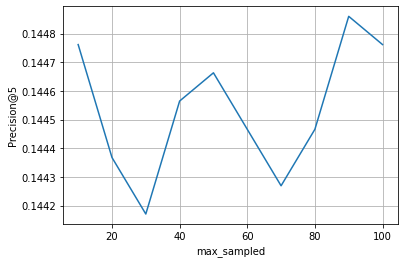

In [45]:
sampleds = np.arange(10, 101, 10)
scores = []

for sampled in sampleds:
    scores.append(evaluate_model(max_sampled=sampled, **best_params))

plt.plot(sampleds, scores)
plt.xlabel('max_sampled')
plt.ylabel('Precision@5')
plt.grid()
plt.show()

<ins>Вывод:</ins>  
Величина метрики при различных комбинациях параметров  
меняется хаотически: то снижается в 2 раза, то опять  
повышается. Это происходит при изменении любого из  
проверявшихся параметров, за исключением *max_sampled*,  
который не оказывает существенного влияния на метрику.  
Можно предположить, что оптимальное соотношение параметров  
можно выявить только применив поиск по сетке: найти какую-то  
логику здесь затруднительно. Стоит отметить, что увеличение  
числа факторов выше 25 не привело к повышению метрики.


На всякий случай, оценим ещё влияние random_state. Может быть,  
всё дело в нём:

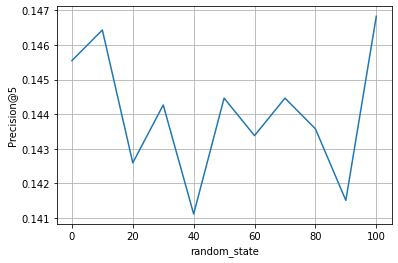

In [49]:
seeds = np.arange(0, 101, 10)
scores = []

for seed in seeds:
    scores.append(evaluate_model(random_state=seed, **best_params))

plt.plot(seeds, scores)
plt.xlabel('random_state')
plt.ylabel('Precision@5')
plt.grid()
plt.show()

Нет, *random_state* не оказывает значительного влияния  
на метрику, значит наши выводы остаются в силе.